In [39]:
#Importamos librerias utiles
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
#leemos nuestras imagenes de textura(serán 4):
tex1 = cv2.imread('texturas/D6.bmp',cv2.IMREAD_GRAYSCALE)
tex2 = cv2.imread('texturas/D64.bmp',cv2.IMREAD_GRAYSCALE)
tex3 = cv2.imread('texturas/D49.bmp',cv2.IMREAD_GRAYSCALE)
tex4 = cv2.imread('texturas/D101.bmp',cv2.IMREAD_GRAYSCALE)
#metemos las imagenes a una lista o bolsa de imagenes
bolsa = [tex1,tex2,tex3,tex4]

#Vemos las imagenes con el visor para tener una idea del tamaño de la ventana
for imagen in bolsa:
    cv2.imshow('Texturas',imagen)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Para tex1 Dado que los bloques son uniformes y alineados. Consideramos un tamaño de ventana de (128,128), considerando que la imagen tiene dimensiones de 640x640 pixeles entonces tendremos a lo largo y a lo ancho 5 ventanas.
Para tex2 tenemos un patron uniforme por lo que consideramos tamaño de la ventana de (107,84). Para este tamaño encontramos un periodo de la red simetrica. Dadas las dimensiones de la imagen y que queremos que se ajuste un numero entero de ventanas a lo largo y ancho de la red, entonces extendemos las dimensiones a (128,128).
Para tex3 debido a que no existe una periodicidad bidireccional, vamos a considerar un tamaño de (128,128).
En tex4 observamos una curvatura inherente a la imagen por lo que vamos a considerar un tamaño equivalente a nueve unidades de la imagen para asi evitar ruido debido a esta curvatura. Este tamaño equivale a una ventana de dimension (114,110). De nuevo debido a las dimensiones de la imagen, el tamaño de la ventana a considerar sera de (128,128).
Note que las redes de las imagenes son altamente periodicas y simetricas, por lo que consideramos que no existe una gran variacion en cuanto a los valores de intensidad y textura con respecto a los pixeles vecinos, es decir, unicamente tomaremos los valores de 25 ventanas para todos los casos

In [2]:
#una vez que ya conocemos el tamaño de las ventanas, nuestro tabajo ahora consiste en obtener los estadisticos de 
#segundo orden.
#https://stackoverflow.com/questions/24893824/levels-parameter-in-greycomatrix-scikit-image-python
#https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix
result = greycomatrix(tex1, distances = [1], angles = [0], symmetric=True)
result[:,:,0,0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [3]:
#probamos con la matriz de ejemplo del tutorial de texturas proporcionado por
#los profesores. El pdf puede encontrarse en la siguiente direccion:
#https://prism.ucalgary.ca/handle/1880/51900
#la prueba sirve para entender la funcion proporcionada por scikit-image
image = np.array([[0, 0, 1, 1],[0, 0, 1, 1],[0, 2, 2, 2],[2, 2, 3, 3]], dtype=np.uint8)
resultado = greycomatrix(image,distances=[1],angles=[0],levels=4,symmetric=True)
glcm = resultado[:,:,0,0]
print(glcm)
contraste = greycoprops(resultado,'contrast')
contraste[0][0]

[[4 2 1 0]
 [2 4 0 0]
 [1 0 6 1]
 [0 0 1 2]]


0.5833333333333333

La Documentacion de scikit image de la funcion greycopropos nos proporciona 6 propiedades de la imagen a partir de la matriz GCLM. Estas seis propiedades son: Contraste, disimilitud, homogeneidad, ASM, energia y correlacion. Una imagen de la misma documentacion se muestra a continuacion.
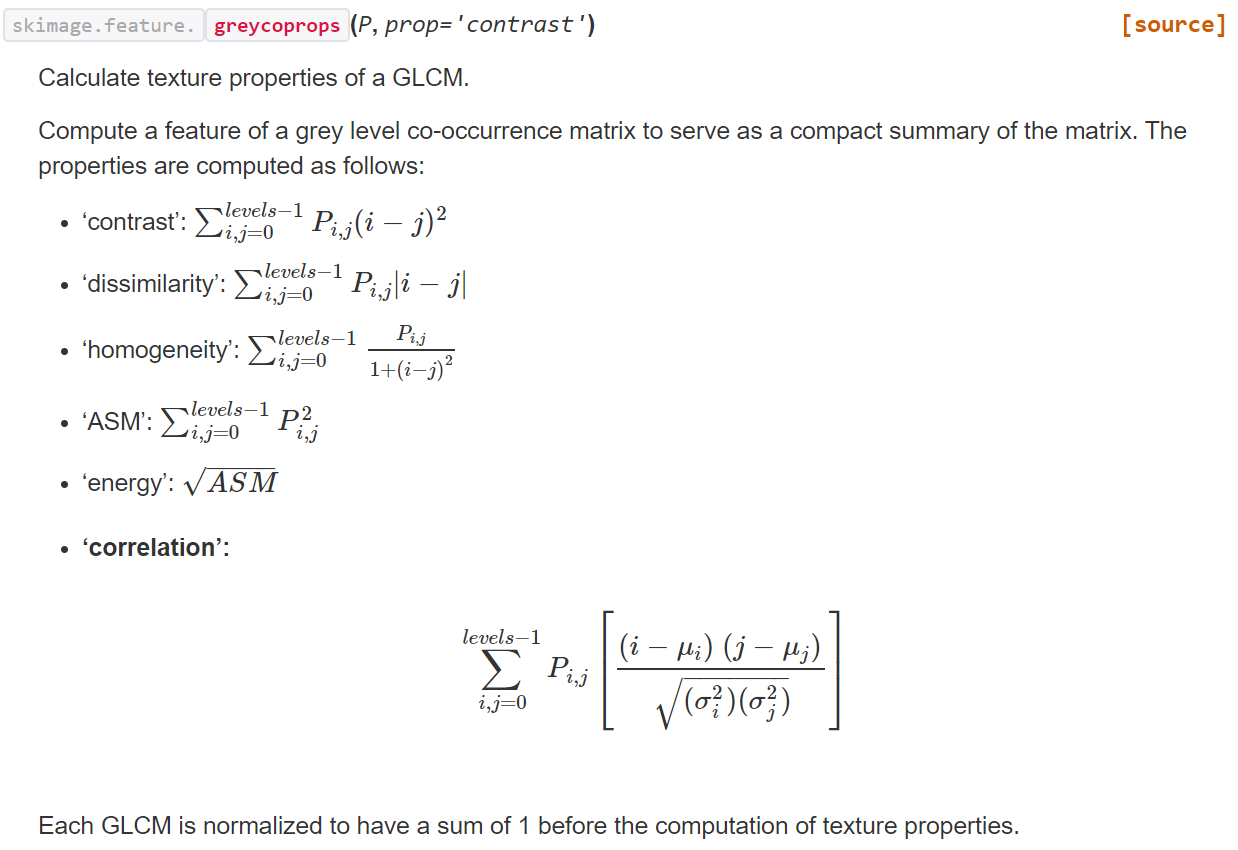

In [4]:
#Dado que forzamos que las ventanas entren en las imagenes (es decir evitamos algun tipo
#de overflow) simplemente debemos hacer dos ciclos for que iteren sobre la imagen
#de acuerdo al tamaño de la ventana y para cada iteracion calcular la matriz GCLM
#para asi obetener los valores deseados y guardarlos en un array.

#Primero creamos un array donde almacenaremos los valores, segun el tamaño de la ventana.
#Las dimensiones del array son (4,6,25), 4 porque cada dimension corresponderá a una imagen de textura
#6 porque son 6propiedades y 25 ya que recorreremos la ventana 25 veces (cubriremos la imagen con 25 ventanas)
propiedades = np.zeros((4,25,6),dtype=float)

#creamos una variable auxiliar para contar las imagenes analizadas en el ciclo for
contadorImagen = 0
#creamos los ciclos de iteracion
#iteramos sobre todas las imagenes
for imagen in bolsa:
    contadorVentana = 0
    #iteramos sobre las filas ponemos el centro de la ventana inicial en imagen.shape[0]/10 = 64
    #hasta llegar a 640 con paso imagen.shape[0]/5=128 que es donde se pondran los centros de la
    #imagen
    for filas in range(int(imagen.shape[0]/10),int(imagen.shape[0]),int(imagen.shape[0]/5)):
        #iteramos sobre las columnas ponemos el centro de la ventana inicial en imagen.shape[0]/10 = 64
    #hasta llegar a 640 con paso imagen.shape[0]/5=128 que es donde se pondran los centros de la
    #imagen
        for columnas in range(int(imagen.shape[1]/10),int(imagen.shape[1]),int(imagen.shape[1]/5)):
            ventana = imagen[filas-64:filas+65,columnas-64:columnas+65]
            GLCM = greycomatrix(ventana,distances=[1],angles=[0],symmetric=True)
            contraste = greycoprops(GLCM,'contrast')
            disimilitud = greycoprops(GLCM,'dissimilarity')
            homogeneidad = greycoprops(GLCM,'homogeneity')
            asm = greycoprops(GLCM,'ASM')
            energia = greycoprops(GLCM,'energy')
            correlacion = greycoprops(GLCM,'correlation')
            propiedades[contadorImagen,contadorVentana]=(contraste,disimilitud,homogeneidad,asm,energia,correlacion)
            contadorVentana+=1
    contadorImagen+=1

In [5]:
#creamos cuatro data frames (uno por cada imagen) con las propiedades que obtuvimos previamente
#esto se hace por si se desea guardar la informacion en archivos csv, txt, data etc.
textura1 = pd.DataFrame(propiedades[0])
textura2 = pd.DataFrame(propiedades[1])
textura3 = pd.DataFrame(propiedades[2])
textura4 = pd.DataFrame(propiedades[3])

#renombramos los nombres de las columnas de cada Df:
textura1.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
textura2.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
textura3.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)
textura4.rename(columns={0:'Contraste',1:'Disimilitud',2:'Homegeneidad',3:'ASM',4:'Energia',5:'Correlacion'}, inplace=True)

In [6]:
#apartir de aqui ya tenemos nuestros vectores de atributos X o variables independientes. Hay que agregar las variables 
#dependientes Y. Dado que tenemos 5 clases o categorias tenemos que hacer 5 vectores de dimension (25,1) para
#cada clase y entrenaremos primero un clasificador Bayesiano ingenuo categorico. La dimension de 25 es porque
#tenemos 25 datos de cada clase. Asignaremos valor 1 a la imagen tex1, 2 a la tex2, etc
yTex1 = np.ones((propiedades[0].shape[0]),dtype=int)
yTex2 = 2*np.ones((propiedades[1].shape[0]),dtype=int)
yTex3 = 3*np.ones((propiedades[2].shape[0]),dtype=int)
yTex4 = 4*np.ones((propiedades[3].shape[0]),dtype=int)

#creamos una nueva columna para cada dataframe llamada clase y en dicha columna ponemos el valor de la clase
textura1['Clase'] = yTex1
textura2['Clase'] = yTex2
textura3['Clase'] = yTex3
textura4['Clase'] = yTex4

#creamos un nuevo Dataframe que contendra los 4 df.
Datos = pd.concat([textura1,textura2,textura3,textura4],ignore_index=True)
Datos.head(5)

,Contraste,Disimilitud,Homegeneidad,ASM,Energia,Correlacion,Clase
0,1958.984012,23.753513,0.184362,0.003874,0.062245,0.492462,1
1,1482.354227,19.447614,0.253226,0.010354,0.101755,0.471638,1
2,1509.096294,19.555596,0.250687,0.010210,0.101043,0.472033,1
3,1342.573765,18.466691,0.258279,0.011055,0.105141,0.474136,1
4,1372.338705,18.873650,0.242536,0.008660,0.093058,0.487630,1


In [7]:
#definimos nuestros conjuntos de entrenamiento de acuerdo a el df Datos
xTrain = (Datos.drop(columns=['Clase'])).to_numpy()
yTrain = (Datos['Clase']).to_numpy()
#definimos y entrenamos nuestro clasificador categorico de bayes
categoricaBayes = CategoricalNB()
categoricaBayes.fit(xTrain,yTrain)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
maquinaSoporte = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(maquinaSoporte, xTrain, yTrain, cv=5)
predicted = cross_val_predict(maquinaSoporte, xTrain, yTrain, cv=5)
predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [28]:
z = np.array([1500,13,0.010,0.099,0.50])
print(mm.predict(np.array([[1500,10,0.15,0.010,0.099,0.50]])))

[4]


In [50]:
rs = ShuffleSplit(n_splits=5, test_size=.20, random_state=0)
cont = 6
parametros = np.zeros((30,6),dtype=float)
for train_index, test_index in rs.split(xTrain):
    mm = svm.SVC(kernel='linear', C=1)
    mm.fit(xTrain[train_index],yTrain[train_index])
    j = mm.predict(xTrain[test_index])
    print(accuracy_score(yTrain[test_index], j))
    parametros[cont-6:cont,:]=mm.coef_
    cont+=6
    mm=0

1.0
1.0
1.0
1.0
1.0


In [51]:
parametros

array([[ 2.90159733e-03,  1.79378244e-05,  2.02883742e-07,
         2.17449097e-08,  1.79767600e-07, -1.59955446e-06],
       [ 1.77478299e-03,  2.18079317e-05, -3.32453798e-07,
        -7.20315773e-09, -3.83168955e-08, -8.24503016e-07],
       [-2.87314990e-03,  5.53614731e-01, -2.64197172e-02,
        -4.51624484e-03, -1.62562149e-02, -7.03786135e-02],
       [ 9.09076853e-03,  2.55156658e-04, -9.12734111e-06,
        -3.48959162e-07, -2.18969599e-06, -5.07889061e-06],
       [-4.35120262e-03,  1.20613812e-05, -2.57880810e-06,
        -4.63613808e-07, -1.75702755e-06, -8.52734754e-07],
       [-2.22916951e-03, -2.06482238e-05, -3.26988113e-08,
        -9.74929876e-08, -2.94638292e-07,  1.32689551e-07],
       [ 2.90159731e-03,  1.79378244e-05,  2.02883741e-07,
         2.17449097e-08,  1.79767599e-07, -1.59955446e-06],
       [ 1.77478299e-03,  2.18079316e-05, -3.32453797e-07,
        -7.20315773e-09, -3.83168954e-08, -8.24503015e-07],
       [-2.87452525e-03,  5.24404173e-01, -2.949